In [1]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import mplstereonet
import skimage.exposure
import harmonica as hm
import verde as vd

import micromag as mg

import time

# Read the real data

In [2]:
data_dir = pathlib.Path("..") / "data"
data = mg.load_qdm(data_dir / "Bz_uc0.mat")
data

<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0 5.0
Data variables:
    bz       (y, x) float64 352.4 94.89 41.62 288.4 ... -4.196 -53.56 2.103
Attributes:
    file_name:  ../data/Bz_uc0.mat

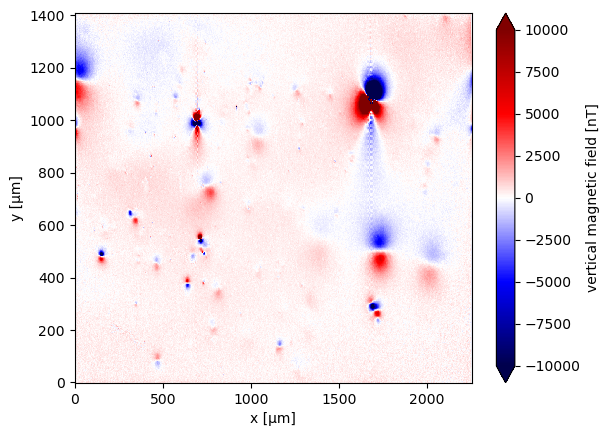

In [3]:
data.bz.plot.pcolormesh(cmap="seismic", vmax=10000, vmin=-10000)

# Anomaly detection

First part of our method is an automatic way to detect and separate the signal of each dipole in the data. This is done in the following steps:

1. Upward continue the data to suppress high frequency noise
2. Calculate the total gradient amplitude (TGA) to concentrate the anomalies on top of the sources
3. Contrast stretch the TGA to highlight weaker sources
4. Run the Laplacian of Gaussian (LoG) method for blog detection to find the anomalies

In [4]:
table = vd.grid_to_table(data)

## 1. Upward continue the data to suppress the high-frequency noise

In this step, we want to upward continue as little as possible to make sure we retain most of the signal.

In [5]:
height_difference = 5

# Have to assign the same points as the data because the Harmonica
# transforms give slightly different coordinates due to round-off.
# This is a bug and is being worked on.
data_up = (
    hm.upward_continuation(data.bz, height_difference)
    .assign_attrs(data.bz.attrs)
    .to_dataset(name="bz")
    .assign_coords(x=data.x, y=data.y)
    .assign_coords(z=data.z + height_difference)
)

data_up.z.attrs = {"units": "µm"}

data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 206.0 199.8 194.2 199.0 ... 282.8 266.5 236.6 204.7

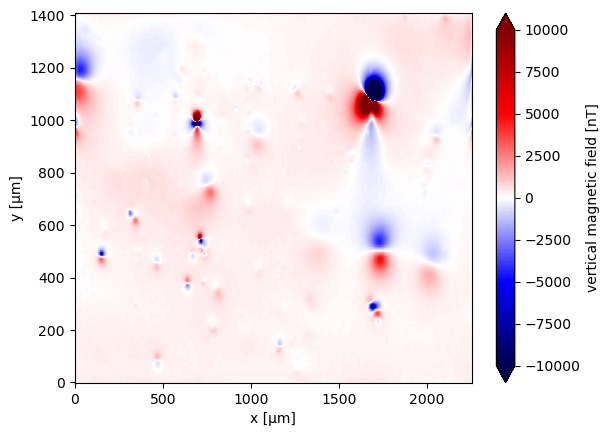

In [6]:
scale = 10000
data_up.bz.plot.pcolormesh(cmap="seismic", vmax=scale, vmin=-scale)

## 2. Calculate the TGA

We do this with finite difference derivatives to avoid amplifying noise.

In [7]:
data_up = data_up.assign(mg.data_gradients(data_up.bz))
data_up

/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/gelson/anaconda3/envs/micromag-euler-dipole/lib/python3.10/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.Dataset>
Dimensions:  (y: 600, x: 960)
Coordinates:
  * x        (x) float64 0.0 2.35 4.7 7.05 ... 2.249e+03 2.251e+03 2.254e+03
  * y        (y) float64 0.0 2.35 4.7 7.05 ... 1.403e+03 1.405e+03 1.408e+03
    z        (y, x) float64 10.0 10.0 10.0 10.0 10.0 ... 10.0 10.0 10.0 10.0
Data variables:
    bz       (y, x) float64 206.0 199.8 194.2 199.0 ... 282.8 266.5 236.6 204.7
    tga      (y, x) float64 6.937 8.888 8.154 6.013 ... 24.89 24.13 23.33 21.11
    x_deriv  (y, x) float64 -2.652 -2.519 -0.1715 3.022 ... -9.835 -13.17 -13.58
    y_deriv  (y, x) float64 6.135 8.487 7.263 4.485 ... -17.43 -11.83 -1.096
    z_deriv  (y, x) float64 1.858 0.7877 3.704 -2.628 ... 16.04 13.48 15.2 16.12

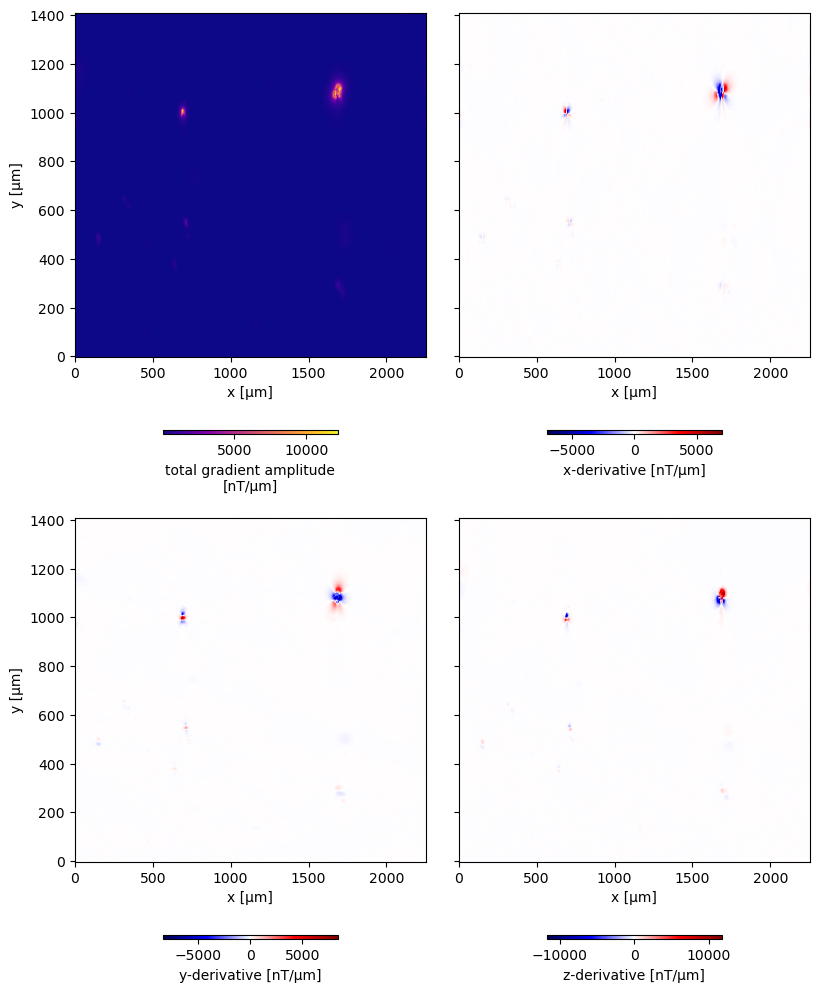

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(8, 10), sharey="row")
cbar_kwargs = dict(orientation="horizontal", aspect=50, pad=0.15, shrink=0.5)
for field, ax in zip(["tga", "x_deriv", "y_deriv", "z_deriv"], axes.ravel()):
    if field == "tga":
        cmap = "plasma"
        vmax=None
        vmin=None
    else:
        vmax= None# 500
        vmin= None#-500
        cmap="seismic"
    data_up[field].plot.pcolormesh(ax=ax, cmap=cmap, cbar_kwargs=cbar_kwargs, vmax=vmax, vmin=vmin)
for ax in axes.ravel():
    ax.set_aspect("auto")
    
axes[0,1].set_ylabel(None)
axes[1,1].set_ylabel(None)
plt.tight_layout(pad=0, h_pad=0, w_pad=2)

## 3. Stretch the contrast

Now we need to stretch the contrast of the TGA to make the anomalies easier to detect.

In [9]:
stretched = skimage.exposure.rescale_intensity(
    data_up.tga, 
    in_range=tuple(np.percentile(data_up.tga, (1, 99))),
)

data_up = data_up.assign(tga_stretched=xr.DataArray(stretched, coords=data_up.coords))

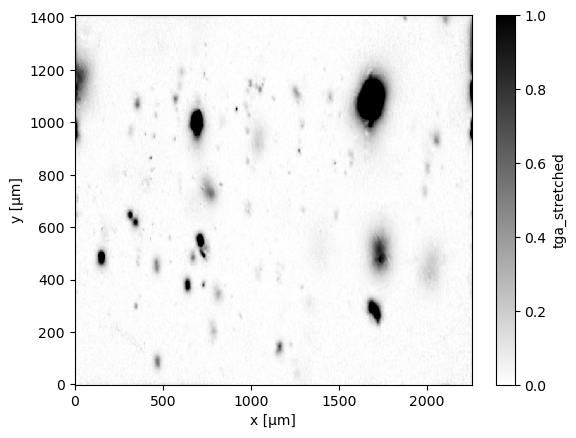

In [10]:
data_up.tga_stretched.plot.pcolormesh(cmap="gray_r")

## 4. Blob detection

To detect the bounding boxes of each anomaly, we use the LoG method in scikit-image. The code below calls it with some conveniences, like passing the range of anomaly sizes in physical units (µm) instead of number of pixels. It returns the bounding box of each anomaly (x_min, x_max, y_min, y_max) also in physical units.

In [11]:
start_detection_time = time.perf_counter()

windows = mg.detect_anomalies(
    data_up.tga_stretched, 
    size_range=[20, 200],
    size_increment=1.3,
    threshold=0.025,
    overlap=0.0,
    exclude_border=30,
    nsizes=10,
)

end_detection_time = time.perf_counter()

In [12]:
detection_time = end_detection_time-start_detection_time

print(f'{np.shape(windows)[0]} potential sources detected within {round(detection_time, 4)} seconds', )

100 potential sources detected within 2.8098 seconds


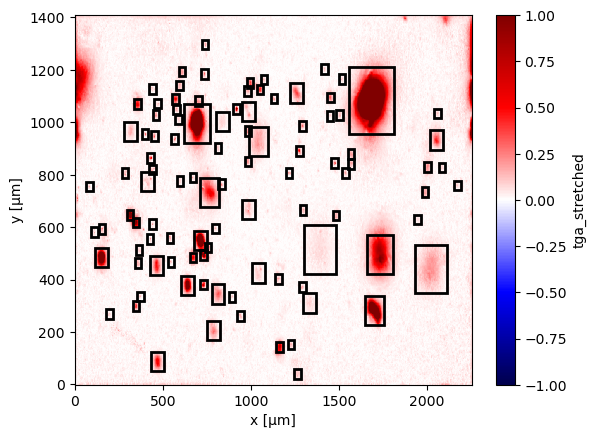

In [13]:
ax = plt.subplot(111)
scale = 1
data_up.tga_stretched.plot.pcolormesh(ax=ax, cmap="seismic", vmax=scale, vmin=-scale)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)  
ax.set_aspect("auto")

Now that we know the bounding box of each anomaly, we can run the Euler deconvolution and moment inversion for each anomaly separately.

# Euler Deconvolution and Inversion (Standard method)

Run the Euler Deconvolution and the inversion on each window.

In [14]:
start_inversion_time = time.perf_counter()

positions = []
estimated_dipole_moments = []
estimated_stds = []
calculated_r2 = []
calculated_SNR = []
windows_filtered = []
base_levels = []
for window in windows:
    anomaly = data_up.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     anomaly = data.sel(x=slice(*window[:2]), y=slice(*window[2:]))
#     base_level = 0
    
    data_minus_background = anomaly.bz.values - base_level
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(
        anomaly.data_minus_background, position,
    )
    
    # Filter out solutions that don't meet quality criteria
    bad_euler = False#position[2] > 0
    poor_fit = False
#     poor_fit = r2 < 0.85
    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s"%(r2,SNR))  
    positions.append(position)  
    estimated_dipole_moments.append(moment)
    estimated_stds.append(mg.covariance_to_angle_std(moment, covariance))
    calculated_r2.append(r2)
    calculated_SNR.append(SNR)
    windows_filtered.append(window)
    base_levels.append(base_level)
positions = np.transpose(positions)


end_inversion_time = time.perf_counter()

In [15]:
inversion_time = end_inversion_time-start_inversion_time
print(f"{positions.shape[1]} euler positions and dipole moments estimated within {round(inversion_time, 4)} seconds", )

100 euler positions and dipole moments estimated within 2.2445 seconds


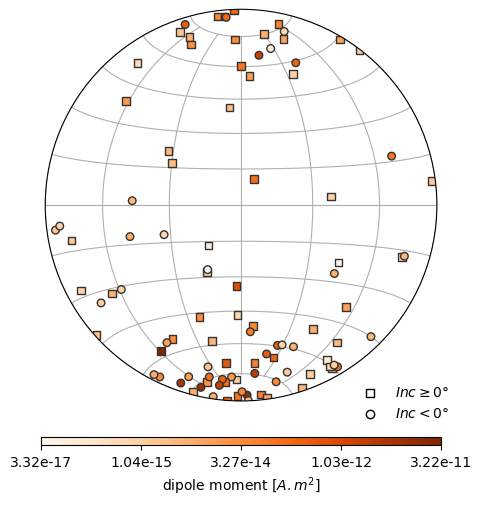

In [16]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

# Interactive Euler deconvolution

In [17]:
x_, y_ = np.meshgrid(data.x.values, data.y.values)
coordinates = ([x_, y_ , data_up.z.values])
# predicted_data = mg.dipole_bz(predicted_coordinates, positions, estimated_dipole_moments)

In [18]:
import warnings
import rich.progress

warnings.filterwarnings("ignore")

start_itr_euler_time = time.perf_counter()

x_concat = []
y_concat = []
z_concat = []
bz_concat = []
xc_concat = []
yc_concat = []
zc_concat = []
z_deriv_concat = []

estimated_dipole_moments_itr_euler = []

# fitting parameters
# calculated_r2 = []
# calculated_SNR = []

data_copy = data.copy(deep=True)
data_up_copy = data_up.copy(deep=True)

################################# identify and remove all models with r2 >= 0.99 at once
euler_r2 = np.array(calculated_r2) > 0.9

for window in rich.progress.track(np.array(windows_filtered)[euler_r2], total = len(np.array(windows_filtered)[euler_r2])):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )

    data_minus_background = anomaly.bz.values #- base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    # store the results with the itr Euler (without interfering sources)
    estimated_dipole_moments_itr_euler.append(moment)

      ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])  

# remove all signals 
position = np.array([xc_concat, yc_concat, zc_concat])
discard = mg.dipole_bz(coordinates, position, estimated_dipole_moments_itr_euler)
data_copy.bz.values -= discard



#################################
for window in rich.progress.track(np.array(windows_filtered)[~euler_r2], total = len(np.array(windows_filtered)[~euler_r2])):
    anomaly = data_up_copy.sel(x=slice(*window[:2]), y=slice(*window[2:]))
    position, base_level = mg.euler_deconvolution(
        anomaly.bz, 
        anomaly.x_deriv, 
        anomaly.y_deriv, 
        anomaly.z_deriv,
    )
    
#     # using the real data to perform the dipole moment estimation
#     data_minus_background = data_copy['bz'].sel(x=slice(*window[:2]), y=slice(*window[2:])).values 
    data_minus_background = anomaly.bz.values #- base_level 
    anomaly = anomaly.assign(data_minus_background=(['y','x'], data_minus_background))
    anomaly.data_minus_background.attrs = {"long_name": "dipole-model", "units": "nT"}
    
    moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.data_minus_background, position)
    
    # store the results with the itr Euler (without interfering sources)
    estimated_dipole_moments_itr_euler.append(moment)
    
    #########
    
    discard = mg.dipole_bz(coordinates, position, moment)

    data_copy.bz.values -= discard
    
#     print(discard.max())
    data_up_copy = (
                hm.upward_continuation(data_copy.bz, height_difference)
                .assign_attrs(data_copy.bz.attrs)
                .to_dataset(name="bz")
                .assign_coords(x=data_copy.x, y=data_copy.y)
                .assign_coords(z=data_copy.z + height_difference)
                   )
    
    
    data_up_copy = data_up_copy.assign(mg.data_gradients(data_up_copy.bz))
    
    
    ########
    # Filter out solutions that don't meet quality criteria
    bad_euler = False #position[2] > 0.0
    poor_fit =  False # r2 < 0.85  

    if bad_euler or poor_fit:
        continue
#     print("R²: %s and SNR: %s | %s"%(r2,SNR,position[2]))  
    xx, yy = np.meshgrid(anomaly.x.values, anomaly.y.values)
    x_concat = np.append(x_concat, xx)
    y_concat = np.append(y_concat, yy)    
    z_concat = np.append(z_concat, anomaly.z.values)
    bz_concat = np.append(bz_concat, anomaly.bz.values)
    z_deriv_concat = np.append(z_deriv_concat, anomaly.z_deriv.values)
    xc_concat = np.append(xc_concat, position[0])
    yc_concat = np.append(yc_concat, position[1])
    zc_concat = np.append(zc_concat, position[2])
#     calculated_r2 = np.append(calculated_r2, r2)
#     calculated_SNR = np.append(calculated_SNR, SNR)


end_itr_euler_time = time.perf_counter()
warnings.resetwarnings()

Output()

Output()

In [19]:
itr_euler_time = end_itr_euler_time-start_itr_euler_time
print(f"Time for the iterative Euler solution and dipole moment estimation: {round(itr_euler_time, 4)} seconds", )

Time for the iterative Euler solution and dipole moment estimation: 38.1762 seconds


In [20]:
df = pd.DataFrame({'x':x_concat,
                   'y':y_concat,
                   'z':z_concat,
                  'bz':bz_concat,
                 'z_deriv':z_deriv_concat})

df.head()

,x,y,z,bz,z_deriv
0,620.40,923.55,10.0,90.171463,11.829231
1,622.75,923.55,10.0,93.266080,9.281289
2,625.10,923.55,10.0,97.015071,6.140179
3,627.45,923.55,10.0,96.105429,11.207893
4,629.80,923.55,10.0,97.323263,11.580005


In [21]:
positions_itr = np.array([xc_concat, yc_concat, zc_concat])
# print(positions_itr)

## Directions and Dipole Moments comparions

### Iteractive Euler (withou interf. sources)

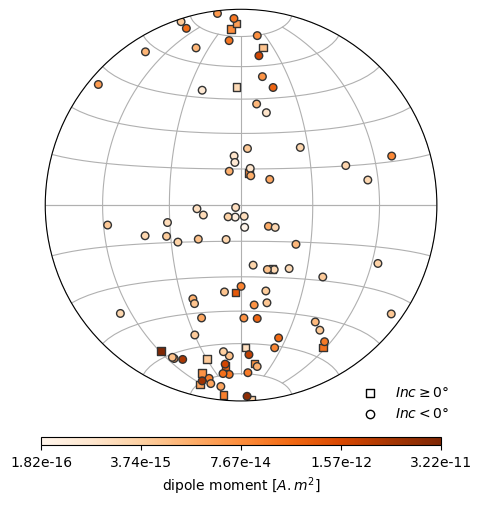

In [22]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_itr_euler)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

### Interfering sources method with $b_z$ vector

In [23]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER

def all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['bz']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['bz']).ravel() / TESLA_TO_NANOTESLA #table.bz.values / TESLA_TO_NANOTESLA
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment 

@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant * choclo.point.kernel_eu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant * choclo.point.kernel_nu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant * choclo.point.kernel_uu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            


In [24]:
start_interf_bz_time = time.perf_counter()

estimated_dipole_moments_interf_bz = all_dipole_moment_inversion(df, positions_itr)
# print(estimated_dipole_moments_interf_bz)

end_interf_bz_time = time.perf_counter()

In [25]:
interf_bz_time = end_interf_bz_time-start_interf_bz_time
print(f"Time for the iterative Euler solution and interfering sources bz estimation: {round(itr_euler_time+interf_bz_time, 2)} seconds", )

Time for the iterative Euler solution and interfering sources bz estimation: 39.27 seconds


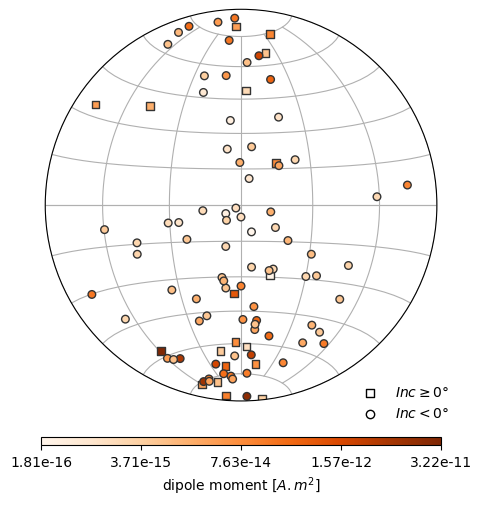

In [26]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_interf_bz)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

### Interfering sources method with $\frac{\partial b_z}{\partial z}$ vector

In [27]:
import numba
import choclo
import scipy
from micromag import TESLA_TO_NANOTESLA, MICROMETER_TO_METER


from numba import jit

@jit(nopython=True)
def kernel_uuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along upward-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.


    """
    return 9 * (upward_p - upward_q) / distance**5 - 15 * (upward_p - upward_q)**3 / distance**7



@jit(nopython=True)
def kernel_euu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (easting_p - easting_q) / distance**5 
            - 15 * (easting_p - easting_q) * (upward_p - upward_q)**2 / distance**7)


@jit(nopython=True)
def kernel_nuu(
    easting_p, northing_p, upward_p, easting_q, northing_q, upward_q, distance
):
    r"""
    Second derivative of the inverse of the distance along easting-upward

    .. important ::

        The coordinates of the two points must be in Cartesian coordinates and
        have the same units.

    Parameters
    ----------
    easting_p : float
        Easting coordinate of point :math:`\mathbf{p}`.
    northing_p : float
        Northing coordinate of point :math:`\mathbf{p}`.
    upward_p : float
        Upward coordinate of point :math:`\mathbf{p}`.
    easting_q : float
        Easting coordinate of point :math:`\mathbf{q}`.
    northing_q : float
        Northing coordinate of point :math:`\mathbf{q}`.
    upward_q : float
        Upward coordinate of point :math:`\mathbf{q}`.
    distance : float
        Euclidean distance between points :math:`\mathbf{p}` and
        :math:`\mathbf{q}`.

    Returns
    -------
    kernel : float
        Value of the kernel function.
    """
    return (  3 *  (northing_p - northing_q) / distance**5 
            - 15 * (northing_p - northing_q) * (upward_p - upward_q)**2 / distance**7)


def z_deriv_all_dipole_moment_inversion(data, dipole_coordinates):
    
    data = data.to_xarray()
    
    n_data = len(data['z_deriv']) #table.shape[0]
    n_params = len(dipole_coordinates[0])*3
    
    A = np.empty((n_data, n_params))
    
    d = np.array(data['z_deriv']).ravel() #*-1.0e-3 # CONVERTING nT/microm to T/m
    
    # Fill the Jacobian using a fast calculation with numba
    _dipole_jacobian_fast(
        data.x.values * MICROMETER_TO_METER,
        data.y.values * MICROMETER_TO_METER,
        data.z.values * MICROMETER_TO_METER,
        dipole_coordinates[0] * MICROMETER_TO_METER,
        dipole_coordinates[1] * MICROMETER_TO_METER,
        dipole_coordinates[2] * MICROMETER_TO_METER,
        A,
    )
    
    
    
    hessian = A.T @ A
    neg_gradient = A.T @ d
    dipole_moment = scipy.linalg.solve(hessian, neg_gradient, assume_a="pos")
    residuals = d - A @ dipole_moment
    
    dipole_moment = np.reshape(dipole_moment, (int(n_params/3), 3) )
    return dipole_moment * 1.0e-3


@numba.jit(nopython=True, parallel=True)
def _dipole_jacobian_fast(e, n, u, de, dn, du, jacobian):
    """
    This is the bit that runs the fast for-loops
    """
    constant = choclo.constants.VACUUM_MAGNETIC_PERMEABILITY / (4 * np.pi)

    for j in numba.prange(len(de)):
        for i in numba.prange(len(e)):
            # Calculating the distance only once saves a lot of computation time
            distance = choclo.utils.distance_cartesian(
                e[i],
                n[i],
                u[i],
                de[j],
                dn[j],
                du[j],
            )
            # These are the second derivatives of 1/r
            jacobian[i, j*3] = constant*kernel_euu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            jacobian[i, j*3+1] = constant*kernel_nuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance=distance,
            )
            jacobian[i, j*3+2] = constant*kernel_uuu(
                easting_p  =e[i],
                northing_p =n[i],
                upward_p   =u[i],
                easting_q  =de[j],
                northing_q =dn[j],
                upward_q   =du[j],
                distance   =distance,
            )
            

In [28]:
start_interf_z_deriv_time = time.perf_counter()

estimated_dipole_moments_interf_z_deriv = z_deriv_all_dipole_moment_inversion(df, positions_itr)
# print(estimated_dipole_moments_interf_bz)

end_interf_z_deriv_time = time.perf_counter()

In [29]:
interf_z_deriv_time = end_interf_z_deriv_time-start_interf_z_deriv_time
print(f"Time for the iterative Euler solution and interfering sources bz estimation: {round(itr_euler_time+interf_z_deriv_time, 2)} seconds", )

Time for the iterative Euler solution and interfering sources bz estimation: 41.29 seconds


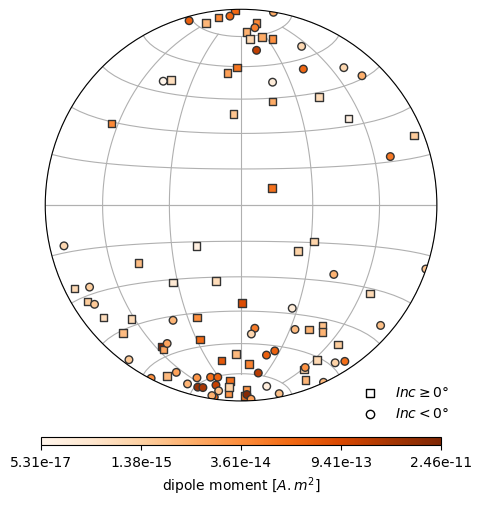

In [30]:
fig, ax = mplstereonet.subplots(1, 1, figsize=(4, 4), constrained_layout=True)
ax.grid()
estimated = mg.vector_to_angles(estimated_dipole_moments_interf_z_deriv)
scatter_args = dict(
    vmin=np.log10(np.min(estimated[2])),
    vmax=np.log10(np.max(estimated[2])),
    cmap="Oranges",
    edgecolors="#333333",
    linewidths=1,
    s=30,
    zorder=2,
)
pos_inc = estimated[0] > 0
tmp = ax.scatter(
    *mplstereonet.line(estimated[0][pos_inc], estimated[1][pos_inc]),
    c=np.log10(estimated[2][pos_inc]),
    marker="s",
    **scatter_args,
)
tmp = ax.scatter(
    *mplstereonet.line(-estimated[0][~pos_inc], estimated[1][~pos_inc]),
    c=np.log10(estimated[2][~pos_inc]),
    marker="o",
    **scatter_args,
)

ticks=np.linspace( np.log10(np.min(estimated[2])),
                   np.log10(np.max(estimated[2])), 5)
tick_labels = []
for i in (ticks):
    tick_labels.append("{:.2e}".format(10**i))

    
clb = fig.colorbar(
    tmp, 
    cax=fig.add_axes([0, -0.1, 1, 0.02]), 
    orientation="horizontal", 
    label="dipole moment [$A.m^2$]",
    format="%.2e",
    ticks = ticks).set_ticklabels(tick_labels)

plt.scatter([],[], marker='s', color='white', edgecolors='k', label=r'$Inc \geq 0° $')
plt.scatter([],[], marker='o', color='white', edgecolors='k', label=r'$Inc < 0° $')

legend = plt.legend(bbox_to_anchor=(1.05, 9.0), frameon=1, framealpha=1.0)
frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')

plt.show()

# Final Comparison

In [31]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

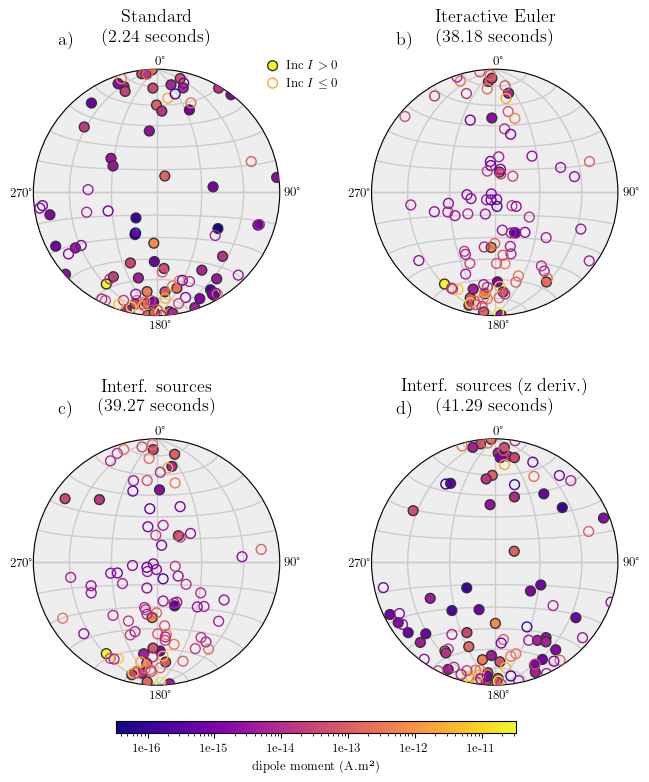

In [32]:
with plt.rc_context(mpl_rc):
    fig = plt.figure(figsize=(8, 8))
    axes = []

#     estimated = mg.vector_to_angles(estimated_dipole_moments)[2]
#     vmin = np.min(estimated)
#     vmax = np.max(estimated)
    
    estimated1 = mg.vector_to_angles(estimated_dipole_moments)[2]
    estimated2 = mg.vector_to_angles(estimated_dipole_moments_itr_euler)[2]
    estimated3 = mg.vector_to_angles(estimated_dipole_moments_interf_bz)[2]
    estimated4 = mg.vector_to_angles(estimated_dipole_moments_interf_z_deriv)[2]
    
    vmin = np.min([np.min(estimated1),np.min(estimated2),np.min(estimated3),np.min(estimated4)])
    vmax = np.max([np.max(estimated1),np.max(estimated2),np.max(estimated3),np.max(estimated4)])
    
    cmap = "plasma"
    # Use matplotlib.colors.LogNorm for a log scale
    cmap_norm = matplotlib.colors.LogNorm #Normalize

        
        
    ## STANDARD METHOD
    ax = fig.add_subplot(2, 2, 1, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments, marker="o", zorder=1000, label="Inc", **kwargs)
    ax.legend(loc=(0.9, 0.9), frameon=False, handletextpad=0.1, prop = {'size' : 9})
    fig.colorbar(
        tmp, 
        cax=fig.add_axes([0.25, 0.05, 0.5, 0.015]), 
        format="%.0g",
        label="dipole moment (A.m²)",
        orientation="horizontal",
    )

    
    
    
    ## ITERACTIVE METHOD
    ax = fig.add_subplot(2, 2, 2, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_itr_euler, marker="o", zorder=1000, label="Inc", **kwargs)

    
    
    ## ITERACTIVE METHOD W/ Bz DATA
    ax = fig.add_subplot(2, 2, 3, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_interf_bz, marker="o", zorder=1000, label="Inc", **kwargs)

    
    
    
    ## ITERACTIVE METHOD W/ Bz deriv DATA
    ax = fig.add_subplot(2, 2, 4, projection='stereonet')
    axes.append(ax)    

    kwargs = dict(
        ax=ax, vmin=vmin, vmax=vmax, s=50, cmap=cmap, cmap_norm=cmap_norm,
    )    
    tmp = mg.plot_stereonet(estimated_dipole_moments_interf_z_deriv, marker="o", zorder=1000, label="Inc", **kwargs)

    
           
    
    
    
    
    titles = ([r'Standard'+'\n'+ f'({round(inversion_time, 2)} seconds)', 
           'Iteractive Euler'+'\n'+ f'({round(itr_euler_time, 2)} seconds)', 
           'Interf. sources'+'\n'+ f'({round(itr_euler_time+interf_bz_time, 2)} seconds)', 
           'Interf. sources (z deriv.)'+'\n'+ f'({round(itr_euler_time+interf_z_deriv_time, 2)} seconds)'])

    for ax, letter, title in zip(axes, "a b c d".split(), titles):
        ax.text(0.1, 1.1, f"{letter})   ", transform=ax.transAxes, fontsize=13)
#         ax.set_azimuth_ticks([])
#         ax.grid(linestyle=':', color='gray')
        ax.set_title(title+'\n', fontsize=13, loc='center')
    fig.subplots_adjust(wspace=0.2, hspace=0.5)

    plt.show()


In [42]:
x_itr, y_itr, z_itr = positions_itr
print(z_itr)

[-5.93025534e+00 -9.90377511e+00 -4.44066259e+00 -8.69940936e+00
 -9.95551980e+00 -1.53444484e+01 -5.97582669e+01 -1.24958009e+01
 -2.27463104e+00 -1.35484396e+01 -1.50935297e+01 -9.74878268e+00
 -4.10322718e+01 -1.35865765e+01 -1.54969869e+01 -1.14530263e+00
 -8.03806410e+00 -1.34392635e+00 -1.98049320e+01 -1.62005266e+01
 -2.38554910e+01 -1.31552954e+01 -4.52679166e+00 -7.41446654e+01
 -6.31950420e+00 -9.49700761e+00 -1.12897443e+01 -4.01467186e+00
 -1.89254409e+01 -4.72619965e+01 -1.65377110e+00 -1.29521172e+01
 -5.50585618e+00  1.96889886e+00  9.87781430e-01 -4.82768674e+00
 -2.20418994e+01 -1.76191706e+01 -1.87675705e+01 -3.30182808e+01
 -1.83300527e+00 -8.21303170e+01 -2.01764679e+01 -1.46628380e+01
 -3.76210274e+00  2.75128802e+00 -3.66842998e-01  2.23708513e+00
 -1.56769423e+01  1.22557577e+00 -1.15030749e+00  6.72607592e-01
  2.69718009e+00  2.71846069e+00  2.35080455e+00 -8.75615425e+00
  1.18814479e+00 -6.88230002e+00 -2.56025892e+00 -4.53846811e-01
 -3.58197851e+00 -1.29290